### Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 13.3 MB/s 


In [3]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf


import cv2
import math
import scipy
import scipy.misc

import skvideo.io

In [4]:
if 1:
    !wget http://www.csc.kth.se/cvap/actions/walking.zip
    !wget http://www.csc.kth.se/cvap/actions/jogging.zip
    !wget http://www.csc.kth.se/cvap/actions/running.zip
    !wget http://www.csc.kth.se/cvap/actions/boxing.zip
    !wget http://www.csc.kth.se/cvap/actions/handwaving.zip
    !wget http://www.csc.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

if 1:
    !7z x walking.zip -y walking > /dev/null
    !7z x jogging.zip -y jogging > /dev/null
    !7z x running.zip -y running > /dev/null
    !7z x boxing.zip -y boxing > /dev/null
    !7z x handwaving.zip -y handwaving > /dev/null
    !7z x handclapping.zip -y handclapping > /dev/null

--2022-12-21 07:31:19--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-12-21 07:31:19--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M  4.55MB/s    in 50s     

2022-12-21 07:32:09 (4.63 MB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-12-21 07:32:09--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c2

In [9]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = [] # Датасет, каждый элемент которого содержит путь к файлу и номер класса
data_root = './' # Путь откуда берём файлы


for cls in classes:
    print(f'Класс обработки: {cls} - {len(os.listdir(cls))} samples')
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):  # Путь к avi-файлам
        cls_idx = classes.index(cls)  # Индекс класса
        dataset.append((fpath, cls_idx))

Класс обработки: walking - 100 samples
Класс обработки: jogging - 100 samples
Класс обработки: running - 100 samples
Класс обработки: boxing - 100 samples
Класс обработки: handwaving - 100 samples
Класс обработки: handclapping - 99 samples


In [10]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Образцы набора данных (подмножество):', len(dataset))

Образцы набора данных (подмножество): 180


In [11]:
random.shuffle(dataset)  # Перемешивание датасета для получения равномерности разных классов

test_count = math.floor(len(dataset)*0.4)

train_ds = dataset[:-test_count]
test_ds = dataset[-test_count:]

In [12]:
len(train_ds), len(test_ds)

(108, 72)

### Визуализация

In [13]:
print(dataset[0][0])
print(dataset[0][1])
print(type(dataset[0][0]))

./boxing/person09_boxing_d2_uncomp.avi
3
<class 'str'>


Форма видеоданных: (432, 120, 160, 3)
Форма видеоданных: (120, 160, 3)


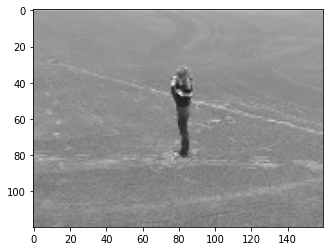

In [14]:
path =  'person01_handwaving_d3_uncomp.avi'
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255. 

print('Форма видеоданных:', videodata.shape)
print('Форма видеоданных:', videodata[50, ...].shape)
plt.imshow(videodata[50, ...])

Форма движения: (431, 120, 160, 1)


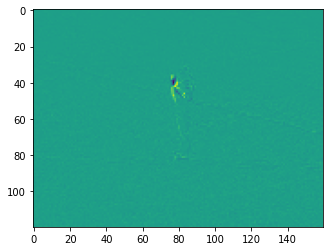

In [15]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('Форма движения:', motion.shape)
plt.imshow(motion[50, ..., 0])

In [16]:
from tensorflow.keras.utils import Sequence

class KTHDataset(Sequence):
    # Подготовка датасета

    def __init__(self, data, max_frames, shuffle=False, batch_size=1, motion=True):
        self.data = data
        self.data_indices = list(range(len(data)))
        self.max_frames = max_frames
        self.shuffle = shuffle
        self.batch_size = batch_size
        if shuffle:
            random.shuffle(self.data_indices)

    def _get_videodata(self, path, motion=True):
        # Чтение данных
        videodata = skvideo.io.vread(path)
        videodata = videodata.astype(np.float32) / 255.

        # Количество повторений до необходимого размера
        n_repeats = (self.max_frames + 1) // videodata.shape[0]
        # Номер последнего кадра
        last_frame = (self.max_frames + 1) - (videodata.shape[0] * n_repeats)

        # Приведение массивов к форме (max_frames, height, width, n_channels)
        # Видео с меньшим кол-вом кадров - повторяется до необходимого размера, с большим - обрезается
        videodata = np.append(
            np.repeat(videodata, n_repeats, axis=0),  # Копировати n_repeats раз
            videodata[:last_frame],   # добавляемые значения
            axis=0
        )

        # "движение"
        if motion:
            videodata = np.mean(
                videodata[1:, ...] - videodata[:-1, ...], 
                axis=3, 
                keepdims=True
            )
        return videodata

    def __getitem__(self, idx, motion=True):
        # Поведение при обращении к объекту
        batch_indices = self.data_indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = []
        batch_y = []
        for i in batch_indices:
            path, label = self.data[i]
            videodata = self._get_videodata(path, motion)
            batch_X.append(videodata)
            batch_y.append(label)
        return np.array(batch_X), np.array(batch_y)

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

In [17]:
import math

# len(train_ds),list(range(len(train_ds)))
# videodata_shape = 392
videodata_shape = 572
max_frames = 4000
batch_size = 400
n_repeats = (max_frames + 1)//videodata_shape
print(videodata_shape, max_frames, n_repeats, (max_frames+1) - videodata_shape*n_repeats)
print(math.ceil(videodata_shape / batch_size), videodata_shape / batch_size)

572 4000 6 569
2 1.43


In [18]:
train = KTHDataset(train_ds, max_frames=400, shuffle=True, batch_size=4)
test = KTHDataset(test_ds, max_frames=400, shuffle=False, batch_size=4)

boxing


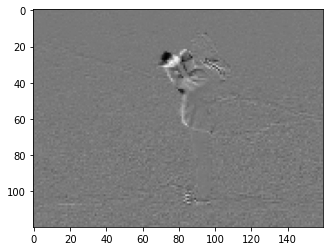

In [19]:
idx = np.random.randint(len(train))

batch_X, batch_y = train[idx]

plt.imshow(batch_X[0][-200, ..., 0], cmap='gray')
print(classes[batch_y[0]])
plt.show()

In [20]:
test_without_motion = KTHDataset(test_ds, max_frames=400, shuffle=False, batch_size=1, motion=False)

handclapping


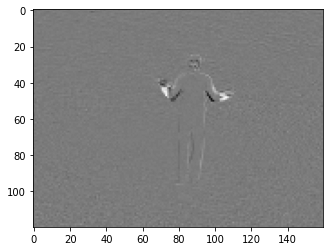

In [21]:
idx = np.random.randint(len(train))

batch_X, batch_y = train[idx]

plt.imshow(batch_X[0][-200, ..., 0], cmap='gray')
print(classes[batch_y[0]])
plt.show()

### Создание модели CNN

In [22]:
model = tf.keras.Sequential([
    # на выходе 32 канала, ядро
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    # 3d-pooling
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    # GlobalAveragePooling3D - все карты признаков агрегирует в одно число
    # GlobalAveragePooling3D - делает усреднение (reduce)
    # по пространственным и временным измерениям (см. ниже)
    # Получится 64 числа (64d-вектор).
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),  # Добавление Dropout
    tf.keras.layers.Dense(6, activation=None),
])

In [23]:
inp = motion[None, ...] # Вход в модель. Добавление batch измерение (Свёрточные сети любят batch).
out = model(inp)

print('Форма ввода:', inp.shape)
print('Форма вывода:', out.shape) # Смотрим на размерность выходного тензора

Форма ввода: (1, 431, 120, 160, 1)
Форма вывода: (1, 6)


### Подготовка к обучению

In [28]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [25]:
if 0:
    !mkdir models

In [26]:
checkpoint_filepath = './models/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

### Цикл обучения модели

In [ ]:
# global_step = 0
# for ep in range(NUM_EPOCHS):
#     for iter, (fpath, label) in enumerate(dataset):
#         videodata = skvideo.io.vread(fpath)
#         videodata = videodata.astype(np.float32) / 255.
#         motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
#         x = motion[None, ...]
#         y = np.array(label)[None, ...]

#         loss_value = model.train_on_batch(x, y)

#         if iter % 10 == 0:
#             print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

#             with writer.as_default():
#                 tf.summary.scalar('loss', loss_value, global_step)

#         global_step += 1

In [29]:
model.fit(train, validation_data=test, epochs=NUM_EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/10
27/27 [==============================] - 102s 4s/step - loss: 1.3314 - val_loss: 1.2815
Epoch 2/10
27/27 [==============================] - 101s 4s/step - loss: 1.0645 - val_loss: 1.1366
Epoch 3/10
27/27 [==============================] - 103s 4s/step - loss: 0.8316 - val_loss: 1.2012
Epoch 4/10
27/27 [==============================] - 103s 4s/step - loss: 0.7778 - val_loss: 1.3312
Epoch 5/10
27/27 [==============================] - 104s 4s/step - loss: 0.6044 - val_loss: 1.3017
Epoch 6/10
27/27 [==============================] - 103s 4s/step - loss: 0.6249 - val_loss: 0.8667
Epoch 7/10
27/27 [==============================] - 104s 4s/step - loss: 0.5695 - val_loss: 1.1737
Epoch 8/10
27/27 [==============================] - 102s 4s/step - loss: 0.5159 - val_loss: 1.0695
Epoch 9/10
27/27 [==============================] - 102s 4s/step - loss: 0.4562 - val_loss: 0.8610
Epoch 10/10
27/27 [==============================] - 102s 4s/step - loss: 0.4765 - val_loss: 1.0309


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, None, None, None,  4032      
                              32)                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, None, None, None,  0        
 )                            32)                                
                                                                 
 conv3d_1 (Conv3D)           (None, None, None, None,  256064    
                              64)                                
                                                                 
 max_pooling3d_1 (MaxPooling  (None, None, None, None,  0        
 3D)                          64)                                
                                                                 
 conv3d_2 (Conv3D)           (None, None, None, None,  1

In [31]:
import pickle

filename = 'finalized_model_1.sav'
pickle.dump(model, open(filename, 'wb'))

### Тестирование обученной модели

Истинный класс: handwaving
Прогнозируемый класс: handwaving


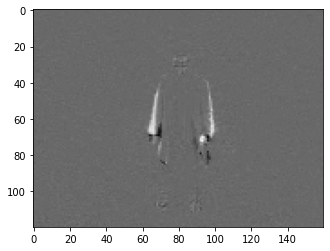

In [32]:
idx = np.random.randint(len(test))

batch_X, batch_y = test[idx]

plt.imshow(batch_X[0][200, ..., 0], cmap='gray')

out = model(batch_X)[0]
cls_pred = np.argmax(out.numpy())

print('Истинный класс:', classes[batch_y[0]])
print('Прогнозируемый класс:', classes[cls_pred])
plt.show()

True class: walking
Predicted class: walking


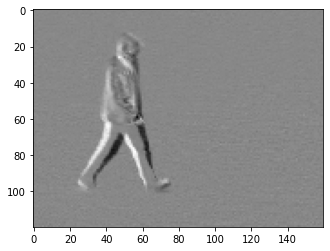

In [33]:
idx = np.random.randint(len(test))

batch_X, batch_y = test[idx]

plt.imshow(batch_X[0][200, ..., 0], cmap='gray')

out = model(batch_X)[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[batch_y[0]])
print('Predicted class:', classes[cls_pred])
plt.show()